# Построение рекомендательной системы с помощью векторного представления графа на основе методов случайного блуждания

In [1]:
import networkx as nx
import numpy as np
import random
import gensim

In [2]:
text = 'A recommender system is a combination of learning algorithms, statistical tools, and recognition algorithms. As a rule, there are three strategies for creating recommender systems: based on content (content-based or item-based), based on a collaborative function (collaborative or user-based), and mixed. The content-based recommender system uses the consumers online history as a pivot. It can be order history, likes, frequently used tags, browser search keywords, and even link clicks. The collaborative feature relies on finding users with similar patterns and offers the user the same recommendation objects that they had. Both strategies have disadvantages, for example, the cold start problem: how to recommend something that no one has used or purchased yet, and what to recommend to a user who has just appeared in the system and has no history? The use of a mixed strategy and the recommendation of the most popular objects (Top-N) helps to solve this problem. Deep learning is actively used to build recommender systems, however, the studies presented in the article have shown that classical approaches to solving this problem are better suited. The authors claim that the graph algorithm based on random walk methods is significantly superior to all existing approaches. In 2020, an article was published on Habré in which the authors propose their version of an improved algorithm, and in the article the author talks about building a graph-based recommender system in the field of logistics. In addition to the areas of application, the recommendation systems presented in them differ significantly in their implementation: for example, the authors have chosen different evaluation metrics, which makes it possible to get acquainted with the advantages of both. For more information on object similarity assessment, see Jacquard Similarity Coefficient, Cosine Distance, and Centered Cosine Distance. After reviewing the literature, it was decided to use a content-based recommender system. First, when working with such a system, information about users and products can be stored separately, which reduces the algorithms running time. Secondly, information about users (interests, geolocation, age, etc., on the basis of which a conclusion is made about the similarity between users) may be absent, while information about products is always there.'
words = text.split(sep=None, maxsplit=-1)
model = gensim.models.Word2Vec([words], min_count=1)

In [4]:
model.wv.most_similar('recommendation')

[('popular', 0.2139120101928711),
 ('approaches.', 0.21226011216640472),
 ('most', 0.20909303426742554),
 ('combination', 0.20782379806041718),
 ('authors', 0.19748468697071075),
 ('just', 0.19259223341941833),
 ('always', 0.18958893418312073),
 ('when', 0.18610629439353943),
 ('walk', 0.18594837188720703),
 ('history?', 0.18516473472118378)]

In [23]:
def generate_walk(G, node):
    """
    генерация случайного блуждания
    """
    walk_len = 15
    neighbors = list(G.neighbors(node))
    if neighbors != []:
        walk = [node]
        cur_state = node
        for t in range(1, walk_len):
            cur_state = random.choices(neighbors)[0]        
            walk.append(cur_state)
            neighbors = list(G.neighbors(cur_state))
    else:
        walk = [node]*walk_len
    return walk

In [196]:
all_nodes = [generate_walk(G, node) for i in range(5) for node in G.nodes()]
words = [list(map(str, node)) for node in all_nodes]
model = gensim.models.Word2Vec(words, min_count=0)

In [3]:
def cold_start(who):
    degr = {i:G.degree[i] for i in range(len(G.nodes()))}
    
    if who == 'user':
        # проблема "холодного старта" для пользователя
        top_k = dict(sorted(degr.items(), key=lambda x: x[1], reverse= True))
        return list(top_k.keys())[:5]
    else:
        # проблема "холодного старта" для узла
        top_k = dict(sorted(degr.items(), key=lambda x: x[1]))
        return list(top_k.keys())[0]

In [4]:
# def recommendation(base):
#     rec = []
#     n = len(base)
#     k = int(n**(-1)*5 + 1)
#     cold = (base == ['None'])
#     if cold == False:
#         isolated = [b for b in base if nx.is_isolate(G, b)]
#         base = [b for b in base if b not in isolated]
#     if cold == False and len(isolated)!=n: 
#         for b in base:
#             top = [int(t[0]) for t in model.wv.most_similar(str(b), topn=len(G)-1) if int(t[0]) not in base]
#             rec.extend(top[:k])
#         cold_node = cold_start('node')
#         if (cold_node not in isolated) and (cold_node not in base):
#             rec.append(cold_node)
#     else:
#         rec = cold_start('user')

#     return set(rec)

In [45]:
def recommendation(base):
    rec = dict()
    n = len(base)
    k = n*2
    cold = (base == ['None'])
    if cold == False:
        isolated = [b for b in base if nx.is_isolate(G, b)]
        base = [b for b in base if b not in isolated]
    if cold == False and len(isolated)!=n: 
        for b in base:
            similarity = [t for t in model.wv.most_similar(str(b), topn=len(G)-1) if int(t[0]) not in base]
            for t in similarity:
                if t[0] not in rec.keys():
                    rec[t[0]] = t[1] 
                else:
                    if t[1] > rec[t[0]]:
                        rec[t[0]] = t[1]
        rec = dict(sorted(rec.items(), key = lambda x: x[1], reverse = True))
        rec = [int(t) for t in rec.keys()][:k]
        cold_node = cold_start('node')
        if (cold_node not in isolated) and (cold_node not in base) and (cold_node not in rec):
            rec.append(cold_node)
    else:
        rec = cold_start('user')
    return rec

# Пример

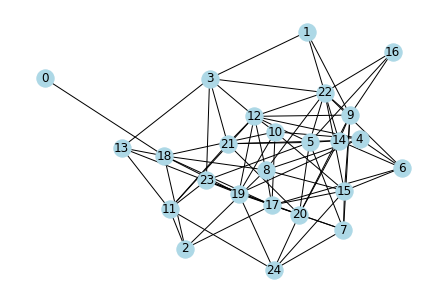

In [222]:
n = 25 
e = n*3
G = nx.dense_gnm_random_graph(n, e)
nx.draw(G, node_color='lightblue', with_labels=True)

In [223]:
all_nodes = [generate_walk(G, node) for i in range(5) for node in G.nodes()]
words = [list(map(str, node)) for node in all_nodes]
model = gensim.models.Word2Vec(words, min_count=0)

In [224]:
recommendation([2, 7, 14, 24])

[15, 11, 12, 17, 19, 20, 23, 9, 0]

In [225]:
recommendation([2])

[11, 15, 0]

In [226]:
recommendation(['None'])

[12, 5, 9, 15, 17]

## Проверка алгоритма на модельных данных

In [227]:
import matplotlib.pyplot as plt
import pandas as pd
import time
from sklearn.model_selection import train_test_split

### Качество

,x,y,egde
0,0,52,"(0, 52)"
1,0,60,"(0, 60)"
2,0,86,"(0, 86)"
3,0,88,"(0, 88)"
4,0,140,"(0, 140)"


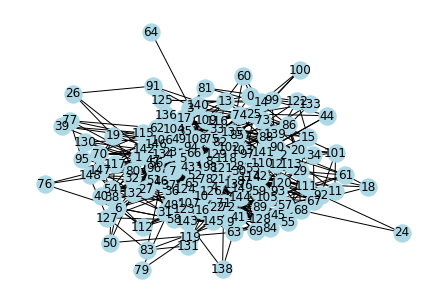

In [228]:
# создание обучающей выборки
n = 150 
e = n*4
G_test = nx.dense_gnm_random_graph(n, e)
nx.draw(G_test, node_color='lightblue', with_labels=True)

G = G_test.copy()

df = pd.DataFrame(None)
df['x'] = [edge[0] for edge in list(G_test.edges())]
df['y'] = [edge[1] for edge in list(G_test.edges())]
df['egde'] = list(G_test.edges())
df.to_csv('Узлы_и_ребра_модельного_графа.csv')
df.head()

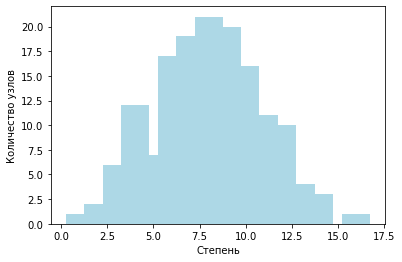

In [229]:
# распределение степеней узлов
n = len(G_test.nodes())
degree = np.array([G_test.degree[i] for i in range(n)])
count = np.unique(degree, return_counts=True)
plt.bar(count[0], count[1], width=1.5, color='lightblue')
plt.xlabel('Степень')
plt.ylabel('Количество узлов');

In [230]:
X_train, X_test, y_train, y_test = train_test_split(df['x'], df['y'], test_size=0.2, shuffle=True)

for index in X_test.index:
    G.remove_edge(*df.iloc[index, 2])
    
x_nodes = [list(X_test[:i]) for i in range(1, len(X_test))]
y_nodes = [list(y_test[:i]) for i in range(1, len(y_test))]

In [231]:
all_nodes = [generate_walk(G, node) for i in range(5) for node in G.nodes()]
words = [list(map(str, node)) for node in all_nodes]
model = gensim.models.Word2Vec(words, min_count=0)

In [232]:
# проверка качества
quality_total = pd.DataFrame(None,
                             columns=['precision@10', 'MRR', 'y_nodes', 'recommendation'])
for i in range(len(x_nodes)):
    rec_4_user = recommendation(x_nodes[i])
    guessed = set(rec_4_user)&set(y_nodes[i]) 
    precision = len(guessed) / len(rec_4_user)
    recall = len(guessed) / len(y_nodes[i])
    quality_total = quality_total.append({'precision@10':round(precision,2),
                                          'MRR':round(recall,2),
                                          'y_nodes':y_nodes[i],
                                          'recommendation':rec_4_user},
                                         ignore_index=True)

In [199]:
quality_total.to_csv('Качество_на_модельном_графе.csv')

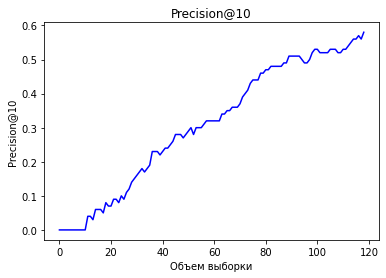

In [233]:
plt.plot(quality_total['precision@10'], color='blue')
plt.title('Precision@10')
plt.xlabel('Объем выборки')
plt.ylabel('Precision@10');

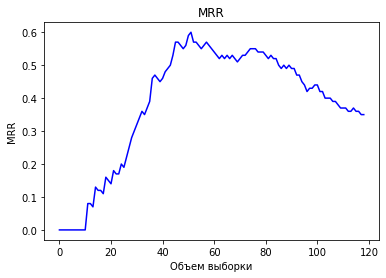

In [234]:
plt.plot(quality_total['MRR'], color='blue')
plt.title('MRR')
plt.xlabel('Объем выборки')
plt.ylabel('MRR');

In [235]:
quality_total.head()

,precision@10,MRR,y_nodes,recommendation
0,0.0,0.0,[114],"[70, 120, 64]"
1,0.0,0.0,"[114, 130]","[70, 139, 120, 38, 64]"
2,0.0,0.0,"[114, 130, 117]","[42, 70, 139, 3, 120, 21, 64]"
3,0.0,0.0,"[114, 130, 117, 47]","[42, 70, 139, 90, 3, 120, 21, 10, 64]"
4,0.0,0.0,"[114, 130, 117, 47, 129]","[42, 70, 139, 90, 3, 120, 21, 10, 144, 92, 64]"


## Проверка работы алгоритма на частных случаях

In [203]:
n = 30 
e = n*2
G = nx.dense_gnm_random_graph(n, e)

node_degree = [G.degree[i]*70 for i in range(len(G.nodes()))]

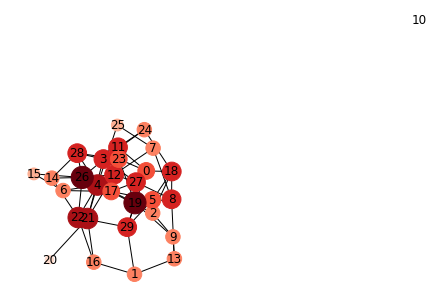

In [207]:
nx.draw(G, with_labels=True,
        node_size = node_degree, node_color = node_degree, cmap=plt.cm.Reds)

In [205]:
all_nodes = [generate_walk(G, node) for i in range(5) for node in G.nodes()]
words = [list(map(str, node)) for node in all_nodes]
model = gensim.models.Word2Vec(words, min_count=0)

In [208]:
recommendation([25])

[4, 21, 10]

In [209]:
recommendation(["None"])

[19, 26, 4, 21, 22]

## Анализ реальных данных

http://orgnet.com/netindustry.html

In [236]:
G_real = nx.read_edgelist('./internet-industry-partnerships.edges', comments='%', delimiter=',', nodetype=int)
len(G_real), len(G_real.edges)

(219, 630)

In [237]:
# Основные характеристики графа
description = {'Количество узлов': len(G_real),
               'Количество ребер': len(G_real.edges()),
               'Минимальный узел': min(G_real.nodes()),
               'Максимальный узел': max(G_real.nodes()),
               'Средняя степень узла': round(len(G_real.edges())/len(G_real)),
               'Плотность': round(nx.density(G_real),5),
               'Диаметр': nx.diameter(G_real)}
df_description = pd.DataFrame.from_dict(description, orient='index')
df_description

,0
Количество узлов,219.00000
Количество ребер,630.00000
Минимальный узел,1.00000
Максимальный узел,219.00000
Средняя степень узла,3.00000
Плотность,0.02639
Диаметр,6.00000


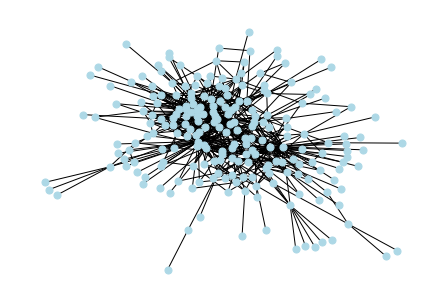

In [238]:
nx.draw(G_real, node_color='lightblue', node_size=50)

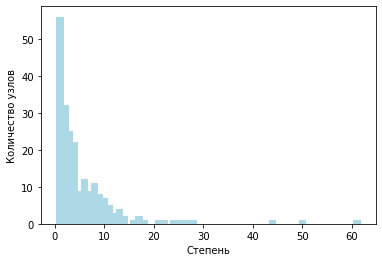

In [239]:
# распределение узлов реального графа
n = len(G_real.nodes())+1
degree = np.array([G_real.degree[i] for i in range(1,n)])
count = np.unique(degree, return_counts=True)
plt.bar(count[0], count[1], width=1.5, color='lightblue')
plt.xlabel('Степень')
plt.ylabel('Количество узлов');

## Проверка алгоритма на реальных данных

In [240]:
G_real = nx.relabel_nodes(G_real, lambda x: x-1)

In [241]:
G = G_real.copy()

df = pd.DataFrame(None)
df['x'] = [edge[0] for edge in list(G_real.edges())]
df['y'] = [edge[1] for edge in list(G_real.edges())]
df['egde'] = list(G_real.edges())
df.to_csv('Узлы_и_ребра_реального_графа.csv')
df.head()

,x,y,egde
0,2,215,"(2, 215)"
1,2,190,"(2, 190)"
2,2,177,"(2, 177)"
3,2,165,"(2, 165)"
4,2,164,"(2, 164)"


In [242]:
X_train, X_test, y_train, y_test = train_test_split(df['x'], df['y'], test_size=0.1, shuffle=True)

for index in X_test.index:
    G.remove_edge(*df.iloc[index, 2])

# x_nodes = [list(X_test[i:i+5]) for i in range(0, len(X_test)-5)]
# y_nodes = [list(y_test[i:i+5]) for i in range(0, len(y_test)-5)]
x_nodes = [list(X_test[:i]) for i in range(5, len(X_test))]
y_nodes = [list(y_test[:i]) for i in range(5, len(y_test))]

In [243]:
all_nodes = [generate_walk(G, node) for i in range(5) for node in G.nodes()]
words = [list(map(str, node)) for node in all_nodes]
model = gensim.models.Word2Vec(words, min_count=0)

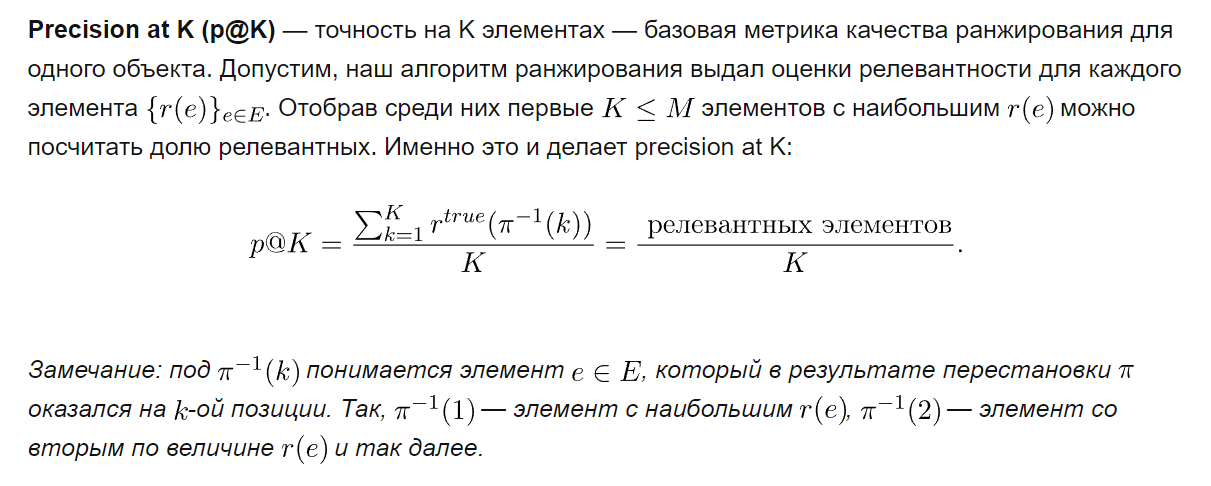

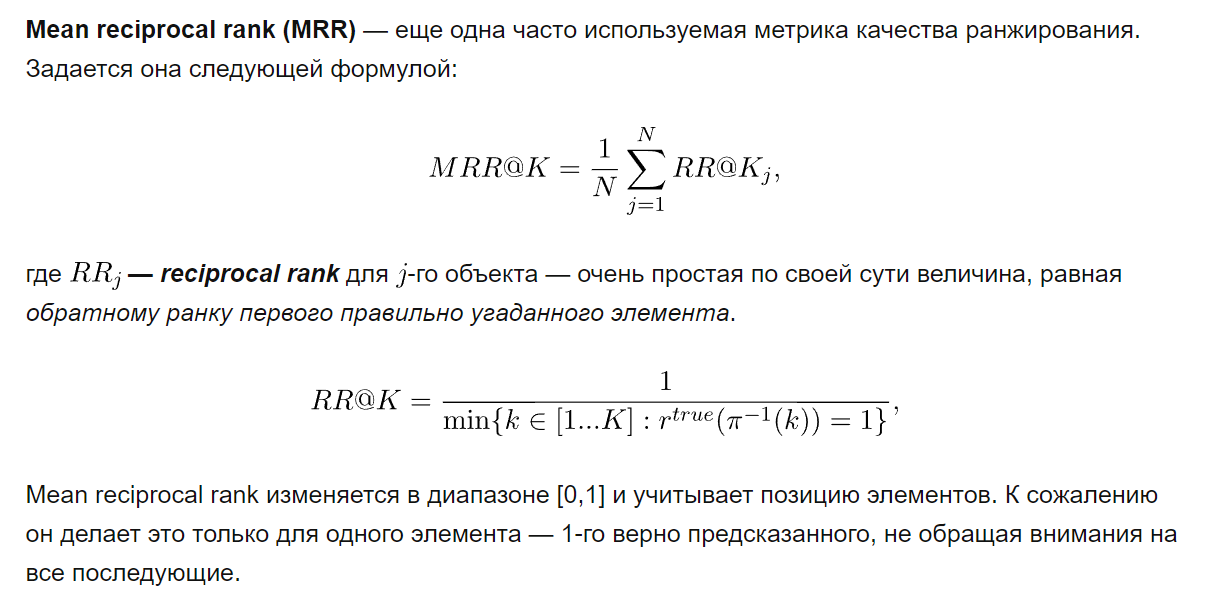

In [244]:
# проверка качества
k = 10
quality_total = pd.DataFrame(None,
                             columns=['precision@10', 'MRR', 'y_nodes', 'recommendation'])

for i in range(4, len(x_nodes)):

    rec_4_user = recommendation(x_nodes[i])
    guessed = [1 if y in y_nodes[i] else 0 for y in rec_4_user][:k]
    precision = sum(guessed) / k
    recall = [1/(rec_4_user.index(y)+1) for y in y_nodes[i] if y in rec_4_user]
    if sum(recall) != 0:
        recall = sum(recall)/len(recall)
    else:
        recall = 0
    quality_total = quality_total.append({'precision@10':round(precision,2),
                                          'MRR':round(recall,2),
                                          'y_nodes':y_nodes[i],
                                          'recommendation':rec_4_user},
                                         ignore_index=True)

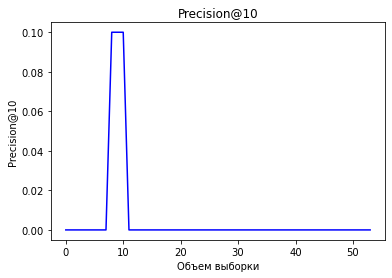

In [245]:
# quality_total.to_csv('Качество_на_реальном_графе.csv')

# print(f'Precision: {quality_total.precision.mean():.2f}')
# print(f'Recall: {quality_total.recall.mean():.2f}')

plt.plot(quality_total['precision@10'], color='blue')
plt.title('Precision@10')
plt.xlabel('Объем выборки')
plt.ylabel('Precision@10');

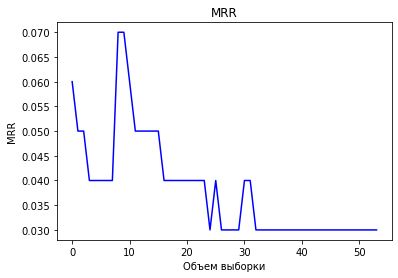

In [246]:
plt.plot(quality_total['MRR'], color='blue')
plt.title('MRR')
plt.xlabel('Объем выборки')
plt.ylabel('MRR');

In [247]:
quality_total.head()

,precision@10,MRR,y_nodes,recommendation
0,0.0,0.06,"[66, 189, 84, 111, 165, 35, 63, 107, 4]","[73, 29, 45, 42, 33, 99, 27, 164, 213, 191, 13..."
1,0.0,0.05,"[66, 189, 84, 111, 165, 35, 63, 107, 4, 25]","[96, 73, 29, 45, 95, 42, 33, 99, 27, 164, 213,..."
2,0.0,0.05,"[66, 189, 84, 111, 165, 35, 63, 107, 4, 25, 16]","[96, 73, 29, 45, 95, 42, 33, 99, 27, 164, 213,..."
3,0.0,0.04,"[66, 189, 84, 111, 165, 35, 63, 107, 4, 25, 16...","[96, 73, 29, 45, 95, 42, 33, 99, 27, 164, 213,..."
4,0.0,0.04,"[66, 189, 84, 111, 165, 35, 63, 107, 4, 25, 16...","[96, 73, 29, 45, 95, 42, 33, 99, 27, 164, 213,..."
